In [26]:
import os
import glob
import math

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [27]:
files = glob.glob(os.path.join(os.getcwd(), "data", "*.tfrecord-*"))
print(f"Found {len(files)} tfrecord files...")

Found 1 tfrecord files...


In [28]:
import tensorflow as tf

num_map_samples = 30000

# Example field definition
roadgraph_features = {
    'roadgraph_samples/dir': tf.io.FixedLenFeature(
        [num_map_samples, 3], tf.float32, default_value=None
    ),
    'roadgraph_samples/id': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/type': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/valid': tf.io.FixedLenFeature(
        [num_map_samples, 1], tf.int64, default_value=None
    ),
    'roadgraph_samples/xyz': tf.io.FixedLenFeature(
        [num_map_samples, 3], tf.float32, default_value=None
    ),
}
# Features of other agents.
state_features = {
    'state/id':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/type':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/is_sdc':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/tracks_to_predict':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/current/bbox_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/height':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/length':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/timestamp_micros':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/valid':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/vel_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/width':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/z':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/future/bbox_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/height':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/length':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/timestamp_micros':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/valid':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/vel_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/width':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/z':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/past/bbox_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/height':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/length':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/timestamp_micros':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/valid':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/vel_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/width':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/z':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
}

traffic_light_features = {
    'traffic_light_state/current/state':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/valid':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/x':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/y':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/z':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/past/state':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/valid':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/x':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/y':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/z':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
}

features_description = {}
features_description.update(roadgraph_features)
features_description.update(state_features)
features_description.update(traffic_light_features)

In [120]:
def filter_stationary_trajs(trajs: np.ndarray, stol: float = 1e-6) -> np.ndarray:
    valid_mask = trajs[:, :, -1] == 1
    trajs = trajs * valid_mask[:, :, None]
    stationary_mask = np.all(np.sqrt(trajs[:, :, 3]**2 + trajs[:, :, 4]**2) < stol, axis=1)
    return trajs[~stationary_mask]

In [121]:
def parse_single_tfrecord(record: bytes, fields: list[str]) -> np.ndarray:
    """Parses a single tfrecord file into a numpy array."""
    parsed = tf.io.parse_single_example(record, features_description)
    vehicle_mask = (parsed["state/type"] == 1)
    concat_features = []

    for field in fields:
        timeranges = (parsed[f"state/past/{field}"].numpy(), parsed[f"state/current/{field}"].numpy(), parsed[f"state/future/{field}"].numpy())
        feat = np.concatenate(timeranges, axis=1)
        concat_features.append(feat[vehicle_mask])

    out_trajs = np.stack(concat_features, axis=2)
    return filter_stationary_trajs(out_trajs)


In [122]:
from scipy.interpolate import interp1d

def resample_traj_2d(timestamps: np.ndarray, traj: np.ndarray, valid_mask: np.ndarray, dt: float = 0.1) -> np.ndarray:
    """Resamples a 2D trajectory to have a fixed number of samples."""
    t_min, t_max = timestamps[valid_mask][0], timestamps[valid_mask][-1]
    num_samples = math.ceil((t_max - t_min) / (dt * 1e6))
    target_timestamps = np.linspace(t_min, t_max, num=num_samples)

    interpolated_features = []
    for i in range(traj.shape[1]):
        interp_func = interp1d(timestamps[valid_mask], traj[valid_mask][:, i], kind="cubic", fill_value="extrapolate")
        interpolated_features.append(interp_func(target_timestamps))

    interpolated_features = np.stack(interpolated_features, axis=1)
    return interpolated_features

In [156]:
def pad_traj_to_fixed_length(traj: np.ndarray, length: int) -> np.ndarray:
    """Left pads a trajectory to a fixed length with first timestep."""

    if traj.shape[0] >= length:
        return traj[:length]
    
    padding = np.tile(traj[0], (length - traj.shape[0], 1))
    return np.concatenate([padding, traj], axis=0)

In [157]:
fields = ["timestamp_micros", "x", "y", "velocity_x", "velocity_y", "bbox_yaw", "valid"]
dataset = tf.data.TFRecordDataset(files, compression_type="")

parsed = parse_single_tfrecord(next(dataset.as_numpy_iterator()), fields)
print(parsed.shape)

(11, 91, 7)


2024-12-01 01:55:30.074163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


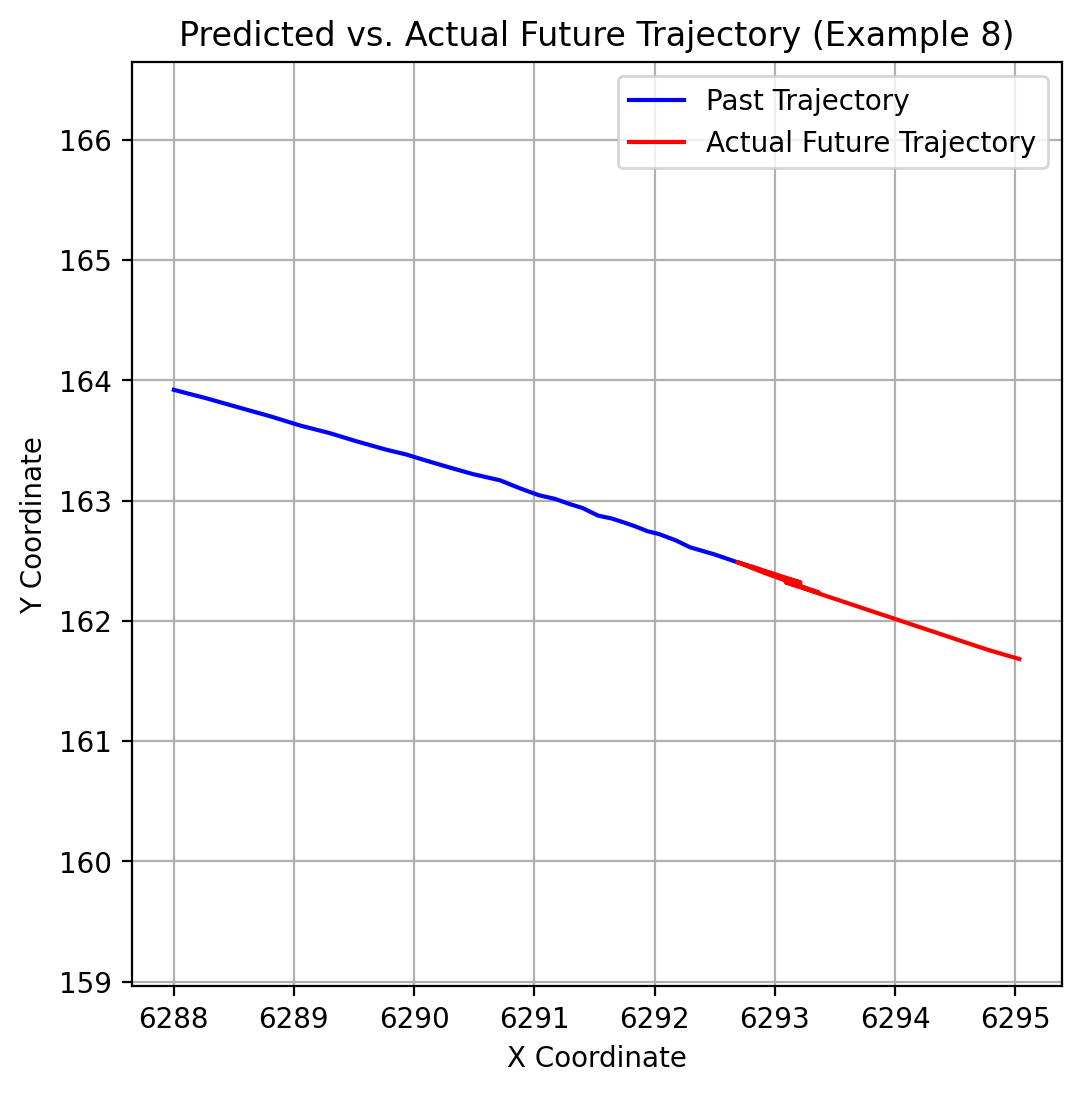

In [161]:
traj_index = 8
traj = parsed[traj_index]
resampled_traj = resample_traj_2d(traj[:, 0], traj[:, 1:6], parsed[traj_index][:, 6] == 1)

final_traj = pad_traj_to_fixed_length(resampled_traj, 90)

# Plot the past trajectory and the future trajectory
plt.figure(figsize=(6, 6))
plt.plot(final_traj[:80, 0], final_traj[:80, 1], label='Past Trajectory', color='blue')
plt.plot(final_traj[80:, 0], final_traj[80:, 1], label='Actual Future Trajectory', color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {traj_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()